## Imports, API access, and cache directory

In [1]:
import os, json, time, hashlib
import requests
from pathlib import Path

from dotenv import load_dotenv

PROJECT_ROOT = Path.cwd().parent
CACHE_DIR = PROJECT_ROOT / "data_cache"
CACHE_DIR.mkdir(exist_ok=True)

load_dotenv((Path.cwd().parent / ".env"))



True

In [2]:
TOKEN = os.getenv("FOOTBALL_DATA_TOKEN")
if not TOKEN:
    raise ValueError("FOOTBALL_DATA_TOKEN not found")

BASE_URL = "https://api.football-data.org/v4"
HEADERS = {"X-Auth-Token": TOKEN}

print("Project root:", PROJECT_ROOT)
print("Cache dir:", CACHE_DIR)

Project root: c:\Users\aryaa\Desktop\actualproj\epl_predictor
Cache dir: c:\Users\aryaa\Desktop\actualproj\epl_predictor\data_cache


In [3]:
def _make_cache_key(url: str, params: dict | None) -> str:

    p = "" if not params else "&".join(f"{k}={params[k]}" for k in sorted(params))
    raw = f"{url}?{p}"
    return hashlib.md5(raw.encode("utf-8")).hexdigest()

def fetch_json(url: str, params: dict | None = None, ttl_seconds: int = 3600) -> dict:
    """
    Fetch JSON from API with simple disk caching.
    - ttl_seconds: reuse cached response if newer than this.
    """
    cache_key = _make_cache_key(url, params)
    cache_file = CACHE_DIR / f"{cache_key}.json"

    if cache_file.exists():
        age = time.time() - cache_file.stat().st_mtime
        if age < ttl_seconds:
            with open(cache_file, "r", encoding="utf-8") as f:
                return json.load(f)
    
    r = requests.get(url, headers=HEADERS, params=params, timeout=30)
    if r.status_code != 200:
        raise RuntimeError(f"API error {r.status_code}: {r.text[:300]}")

    data = r.json()

    # Save cache
    with open(cache_file, "w", encoding="utf-8") as f:
        json.dump(data, f)

    return data

### Testing API Access

##### "Status: 200" and visible data means we are good to go

In [4]:
matches_url = f"{BASE_URL}/competitions/PL/matches"

r = requests.get(matches_url, headers=HEADERS, timeout=30)
print("status:", r.status_code)
print("first 200 chars:", r.text[:200])
r.raise_for_status()

data = r.json()
print("matches returned:", len(data.get("matches", [])))


status: 200
first 200 chars: {"filters":{"season":"2025"},"resultSet":{"count":380,"first":"2025-08-15","last":"2026-05-24","played":254},"competition":{"id":2021,"name":"Premier League","code":"PL","type":"LEAGUE","emblem":"http
matches returned: 380


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

rows = []

for match in data["matches"]:
    rows.append({
        'match_id' : match["id"],
        'utc_date' : match["utcDate"],
        'status' : match["status"],
        'matchday' : match["matchday"],
        'home_team' : match["homeTeam"]["name"],
        'away_team' : match["awayTeam"]["name"],
        'winning_team' : match["score"]["winner"],
        'half_time_score_home' : match["score"]["halfTime"]["home"],
        'half_time_score_away' : match["score"]["halfTime"]["away"],
        'full_time_score_home' : match["score"]["fullTime"]["home"],
        'full_time_score_away' : match["score"]["fullTime"]["away"]
    })

teams = {}
for match in data.get("matches", []):
    for side in ["homeTeam", "awayTeam"]:
        t = match.get(side) or {}
        team_id = t.get("id")
        if team_id is None:
            continue

        teams[team_id] = {
            "team_id": team_id,
            "team_shortname": t.get("shortName") or t.get("name"),
            "team_tla": t.get("tla"),
        }

matches_df = pd.DataFrame(rows)
matches_df["utc_date"] = pd.to_datetime(matches_df["utc_date"], utc=True)

teams_df = pd.DataFrame(list(teams.values())).sort_values("team_shortname")

teams_df = (
    pd.DataFrame(list(teams.values()))
      .sort_values("team_shortname")
      .reset_index(drop=True)
)

#print(matches_df.head())
print(teams_df.head())

   team_id team_shortname team_tla
0       57        Arsenal      ARS
1       58    Aston Villa      AVL
2     1044    Bournemouth      BOU
3      402      Brentford      BRE
4      397  Brighton Hove      BHA


#### Quick visualization of Total Goals per Match so far

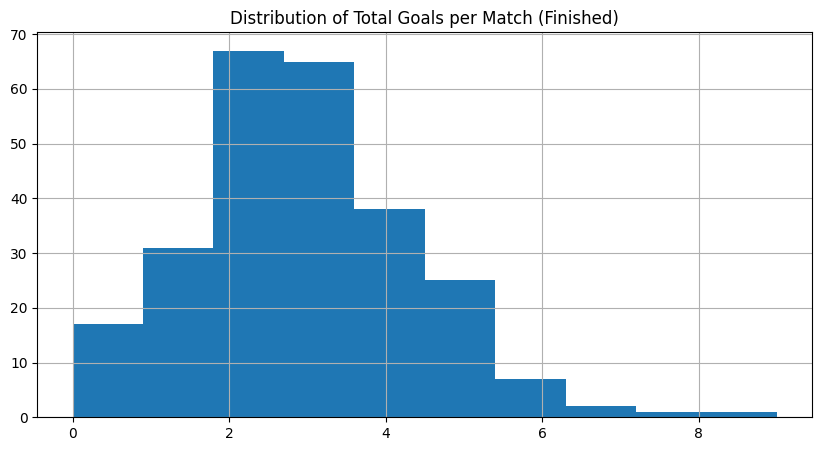

,team_id,team_shortname,team_tla
0,57,Arsenal,ARS
1,58,Aston Villa,AVL
2,1044,Bournemouth,BOU
3,402,Brentford,BRE
4,397,Brighton Hove,BHA
5,328,Burnley,BUR
6,61,Chelsea,CHE
7,354,Crystal Palace,CRY
8,62,Everton,EVE
9,63,Fulham,FUL


In [6]:
finished = matches_df[matches_df["status"] == "FINISHED"].copy()
finished["total_goals"] = finished["full_time_score_home"].fillna(0) + finished["full_time_score_away"].fillna(0)

plt.figure(figsize=(10, 5))
finished["total_goals"].hist(bins=10)
plt.title("Distribution of Total Goals per Match (Finished)")
plt.show()

display(teams_df)


### Loading data into SQL with DuckDB

In [7]:
import duckdb

con = duckdb.connect("epl.duckdb")

con.execute("CREATE OR REPLACE TABLE teams AS SELECT * FROM teams_df")
con.execute("CREATE OR REPLACE TABLE matches AS SELECT * FROM matches_df")

#### Some interesting tables to provide insight

In [ ]:
con.execute("""
CREATE OR REPLACE TABLE match_results_per_team AS 
SELECT 
    utc_date AS match_date, 
    home_team AS team, 
    away_team AS opponent, 
    full_time_score_home AS gf, 
    full_time_score_away AS ga, 

CASE 
    WHEN winning_team = 'HOME_TEAM' THEN 'W' 
    WHEN winning_team = 'AWAY_TEAM' THEN 'L' 
    WHEN winning_team = 'DRAW' THEN 'D' 
    ELSE 'TBD' 
END AS result, 

CASE 
    WHEN result = 'W' THEN 3 
    WHEN result = 'L' THEN 0 
    WHEN result = 'D' THEN 1 
    ELSE 0 
END AS points, 
FROM matches 

UNION ALL 

SELECT 
    utc_date AS match_date, 
    away_team AS team, 
    home_team AS opponent, 
    full_time_score_away AS gf, 
    full_time_score_home AS ga, 

CASE 
    WHEN winning_team = 'AWAY_TEAM' THEN 'W' 
    WHEN winning_team = 'HOME_TEAM' THEN 'L' 
    WHEN winning_team = 'DRAW' THEN 'D' 
    ELSE 'TBD' 
END AS result, 

CASE 
    WHEN winning_team = 'AWAY_TEAM' THEN 3 
    WHEN winning_team = 'HOME_TEAM' THEN 0 
    WHEN winning_team = 'DRAW' THEN 1 
    ELSE 0 
    END AS points 
FROM matches;"""
)

In [12]:
con.query("SELECT * FROM match_results_per_team")

┌──────────────────────────┬────────────────────────────┬───────────────────────────┬────────┬────────┬─────────┬────────┐
│        match_date        │            team            │         opponent          │   gf   │   ga   │ result  │ points │
│ timestamp with time zone │          varchar           │          varchar          │ double │ double │ varchar │ int32  │
├──────────────────────────┼────────────────────────────┼───────────────────────────┼────────┼────────┼─────────┼────────┤
│ 2025-08-15 12:00:00-07   │ Liverpool FC               │ AFC Bournemouth           │    4.0 │    2.0 │ W       │      3 │
│ 2025-08-16 04:30:00-07   │ Aston Villa FC             │ Newcastle United FC       │    0.0 │    0.0 │ D       │      1 │
│ 2025-08-16 07:00:00-07   │ Brighton & Hove Albion FC  │ Fulham FC                 │    1.0 │    1.0 │ D       │      1 │
│ 2025-08-16 07:00:00-07   │ Sunderland AFC             │ West Ham United FC        │    3.0 │    0.0 │ W       │      3 │
│ 2025-08-16 07:

In [13]:
con.execute("""
CREATE OR REPLACE TABLE last_5_matches AS
SELECT 
    l5.team,
    l5.form,
    l5.last_5_points,
    l5.num_matches,
    total.season_points
FROM (
    SELECT 
        team,
        STRING_AGG(result, '' ORDER BY match_date ASC) AS form,
        SUM(points) AS last_5_points,
        COUNT(*) AS num_matches
    FROM (
        SELECT 
            team,
            result,
            points,
            match_date,
            ROW_NUMBER() OVER (PARTITION BY team ORDER BY match_date DESC) AS match_recency
        FROM match_results_per_team
        WHERE result != 'TBD'
    ) AS recent_matches
    WHERE match_recency <= 5
    GROUP BY team
) AS l5
JOIN (
    SELECT 
        team,
        SUM(points) AS season_points
    FROM match_results_per_team
    WHERE result != 'TBD'
    GROUP BY team
) AS total ON l5.team = total.team
ORDER BY total.season_points DESC, l5.last_5_points DESC
""")

In [14]:
con.query("SELECT * FROM last_5_matches")

┌────────────────────────────┬─────────┬───────────────┬─────────────┬───────────────┐
│            team            │  form   │ last_5_points │ num_matches │ season_points │
│          varchar           │ varchar │    int128     │    int64    │    int128     │
├────────────────────────────┼─────────┼───────────────┼─────────────┼───────────────┤
│ Arsenal FC                 │ DDLWW   │             8 │           5 │            56 │
│ Manchester City FC         │ DLWDW   │             8 │           5 │            50 │
│ Aston Villa FC             │ DLWLD   │             5 │           5 │            47 │
│ Manchester United FC       │ WWWWD   │            13 │           5 │            45 │
│ Chelsea FC                 │ WWWWD   │            13 │           5 │            44 │
│ Brentford FC               │ WLLWW   │             9 │           5 │            39 │
│ Liverpool FC               │ DDLWL   │             5 │           5 │            39 │
│ AFC Bournemouth            │ DWWDW   │   

In [23]:
con.execute("""
CREATE OR REPLACE TABLE attack_defense_strength AS
SELECT
    team,
    SUM(gf) AS total_gf,
    SUM(ga) AS total_ga
FROM match_results_per_team

GROUP BY team
ORDER BY total_gf / total_ga DESC
""")

In [24]:
con.query("SELECT * FROM attack_defense_strength")

┌────────────────────────────┬──────────┬──────────┐
│            team            │ total_gf │ total_ga │
│          varchar           │  double  │  double  │
├────────────────────────────┼──────────┼──────────┤
│ Arsenal FC                 │     49.0 │     17.0 │
│ Manchester City FC         │     51.0 │     24.0 │
│ Chelsea FC                 │     47.0 │     30.0 │
│ Aston Villa FC             │     36.0 │     27.0 │
│ Manchester United FC       │     47.0 │     37.0 │
│ Brentford FC               │     39.0 │     34.0 │
│ Liverpool FC               │     40.0 │     35.0 │
│ Brighton & Hove Albion FC  │     34.0 │     33.0 │
│ Newcastle United FC        │     37.0 │     37.0 │
│ Tottenham Hotspur FC       │     36.0 │     37.0 │
│ Everton FC                 │     29.0 │     30.0 │
│ AFC Bournemouth            │     43.0 │     45.0 │
│ Fulham FC                  │     35.0 │     37.0 │
│ Sunderland AFC             │     27.0 │     29.0 │
│ Crystal Palace FC          │     26.0 │     

In [51]:
con.execute("""
CREATE OR REPLACE TABLE home_vs_away_results AS
SELECT
    team,
    SUM(home_gf) AS home_gf,
    SUM(home_ga) AS home_ga, 
    SUM(away_gf) AS away_gf,
    SUM(away_ga) AS away_ga
FROM (
    SELECT
        team,
        SUM(gf) AS home_gf,
        SUM(ga) AS home_ga,
        0 AS away_gf,
        0 AS away_ga
    FROM match_results_home
    GROUP BY team

    UNION ALL

    SELECT
        team,
        0 AS home_gf,
        0 AS home_ga,
        sum(gf) AS away_gf,
        SUM(ga) AS away_ga
    FROM match_results_away 
    GROUP BY team 
    ) combined
    GROUP BY team
    ORDER BY team;
""")

In [52]:
con.query("SELECT * FROM home_vs_away_results")

┌────────────────────────────┬─────────┬─────────┬─────────┬─────────┐
│            team            │ home_gf │ home_ga │ away_gf │ away_ga │
│          varchar           │ double  │ double  │ double  │ double  │
├────────────────────────────┼─────────┼─────────┼─────────┼─────────┤
│ AFC Bournemouth            │    20.0 │    14.0 │    23.0 │    31.0 │
│ Arsenal FC                 │    31.0 │     8.0 │    18.0 │     9.0 │
│ Aston Villa FC             │    18.0 │    10.0 │    18.0 │    17.0 │
│ Brentford FC               │    23.0 │    12.0 │    16.0 │    22.0 │
│ Brighton & Hove Albion FC  │    20.0 │    14.0 │    14.0 │    19.0 │
│ Burnley FC                 │    12.0 │    19.0 │    13.0 │    30.0 │
│ Chelsea FC                 │    22.0 │    15.0 │    25.0 │    15.0 │
│ Crystal Palace FC          │    11.0 │    15.0 │    15.0 │    14.0 │
│ Everton FC                 │    16.0 │    18.0 │    13.0 │    12.0 │
│ Fulham FC                  │    22.0 │    16.0 │    13.0 │    21.0 │
│ Leed

In [11]:
print(matches_df.head())

   match_id                  utc_date    status  matchday  \
0    537785 2025-08-15 19:00:00+00:00  FINISHED         1   
1    537786 2025-08-16 11:30:00+00:00  FINISHED         1   
2    537787 2025-08-16 14:00:00+00:00  FINISHED         1   
3    537789 2025-08-16 14:00:00+00:00  FINISHED         1   
4    537790 2025-08-16 14:00:00+00:00  FINISHED         1   

                   home_team            away_team winning_team  \
0               Liverpool FC      AFC Bournemouth    HOME_TEAM   
1             Aston Villa FC  Newcastle United FC         DRAW   
2  Brighton & Hove Albion FC            Fulham FC         DRAW   
3             Sunderland AFC   West Ham United FC    HOME_TEAM   
4       Tottenham Hotspur FC           Burnley FC    HOME_TEAM   

   half_time_score_home  half_time_score_away  full_time_score_home  \
0                   1.0                   0.0                   4.0   
1                   0.0                   0.0                   0.0   
2                   0.0